In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
full = pd.read_csv('normalised_growth.csv', index_col=0, header=[0] ,parse_dates=True)
full.head()

,CPIAUCSL,FEDFUNDS,HOUST,INDPRO,INTDSRUSM193N,ISRATIO,M2SL,MTSDS133FMS,PAYEMS,PCE,...,CIVPART,GS20,GS3,IRLTLT01USM156N,M1SL,MCOILWTICO,PPIACO,TCU,TOTALSA,PMI
1914-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.635906,NaN,NaN,NaN
1914-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.543396,NaN,NaN,NaN
1914-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.638258,NaN,NaN,NaN
1914-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.638258,NaN,NaN,NaN
1914-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.640650,NaN,NaN,NaN


In [3]:
sliced = full.loc["1948-01-01":"2019-01-01"]
sliced.shape

(853, 32)

In [4]:
core_series = ["CPIAUCSL", "A191RO1Q156NBEA", "UNRATE"]

core = sliced[core_series]

train = core.loc["1948-01-01":"2006-4-01"]
test = core.loc["2006-05-01":]

print(train.shape)

(700, 3)


In [5]:
# http://www.statsmodels.org/dev/vector_ar.html
from statsmodels.tsa.vector_ar.var_model import VAR

In [6]:
model = VAR(train, freq='MS')
model.select_order(15).summary()

,AIC,BIC,FPE,HQIC
0,-0.2438,-0.2239,0.7837,-0.2361
1,-11.86,-11.78,7.075e-06,-11.83
2,-12.92,-12.78*,2.443e-06,-12.87
3,-12.93,-12.73,2.424e-06,-12.85
4,-12.93,-12.67,2.423e-06,-12.83
5,-12.98,-12.67,2.296e-06,-12.86
6,-12.98,-12.61,2.295e-06,-12.84
7,-12.99,-12.55,2.293e-06,-12.82
8,-13.01,-12.51,2.236e-06,-12.82
9,-13.02,-12.46,2.221e-06,-12.80


In [7]:
results = model.fit(maxlags=15, ic='aic')
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 15, Aug, 2019
Time:                     16:20:34
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -12.6334
Nobs:                     686.000    HQIC:                  -13.1557
Log likelihood:           1834.32    FPE:                1.39181e-06
AIC:                     -13.4854    Det(Omega_mle):     1.15976e-06
--------------------------------------------------------------------
Results for equation CPIAUCSL
                         coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------
const                       0.002217         0.004351            0.510           0.610
L1.CPIAUCSL                 1.314466         0.039264           33.478           0.000
L1.A191RO1Q156NBEA         -0.084

In [8]:
from utils import plot_var_forc

In [9]:
def plot_forecast_custom(results, steps, previous = 20, alpha=0.05, plot_stderr=True):
    mid, lower, upper = results.forecast_interval(results.y, steps=12, alpha=0.05)
    fig = plot_var_forc(results.y[-previous:], mid, lower, upper, names=results.names, plot_stderr=plot_stderr)
    return fig


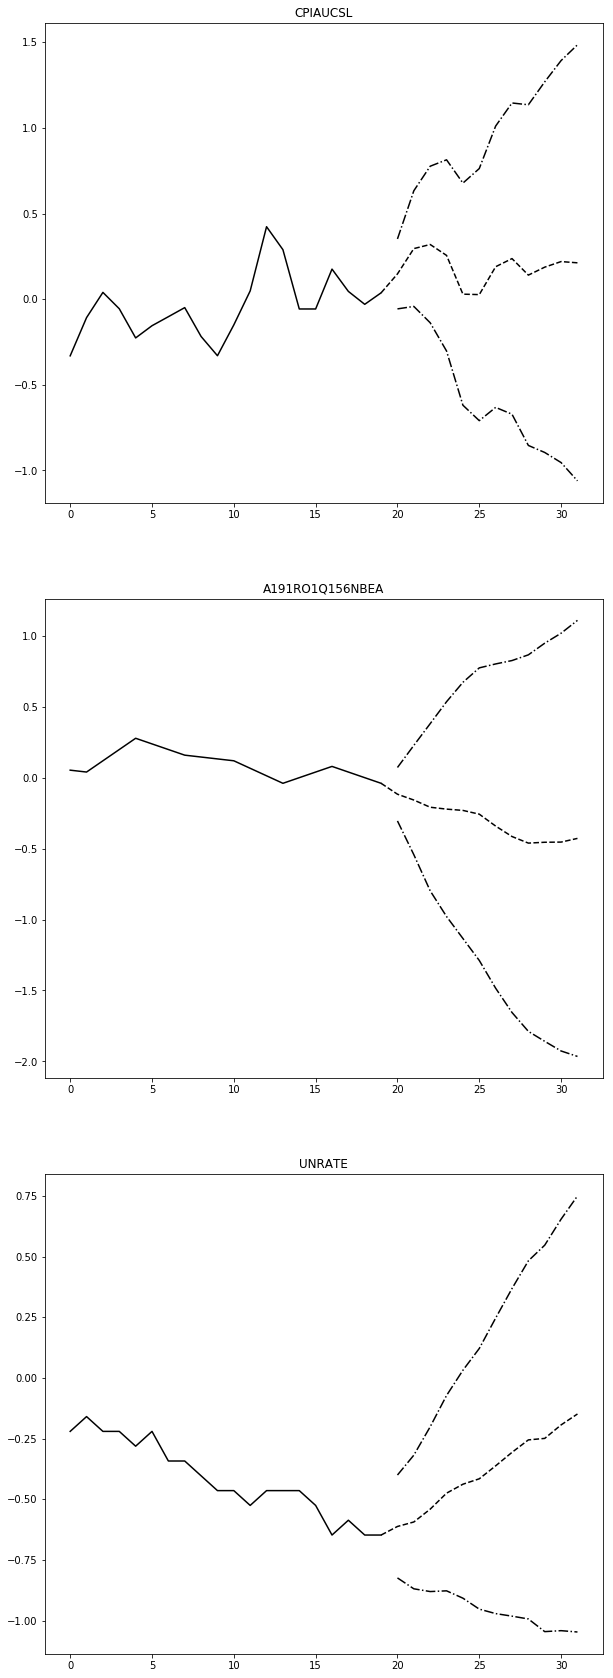

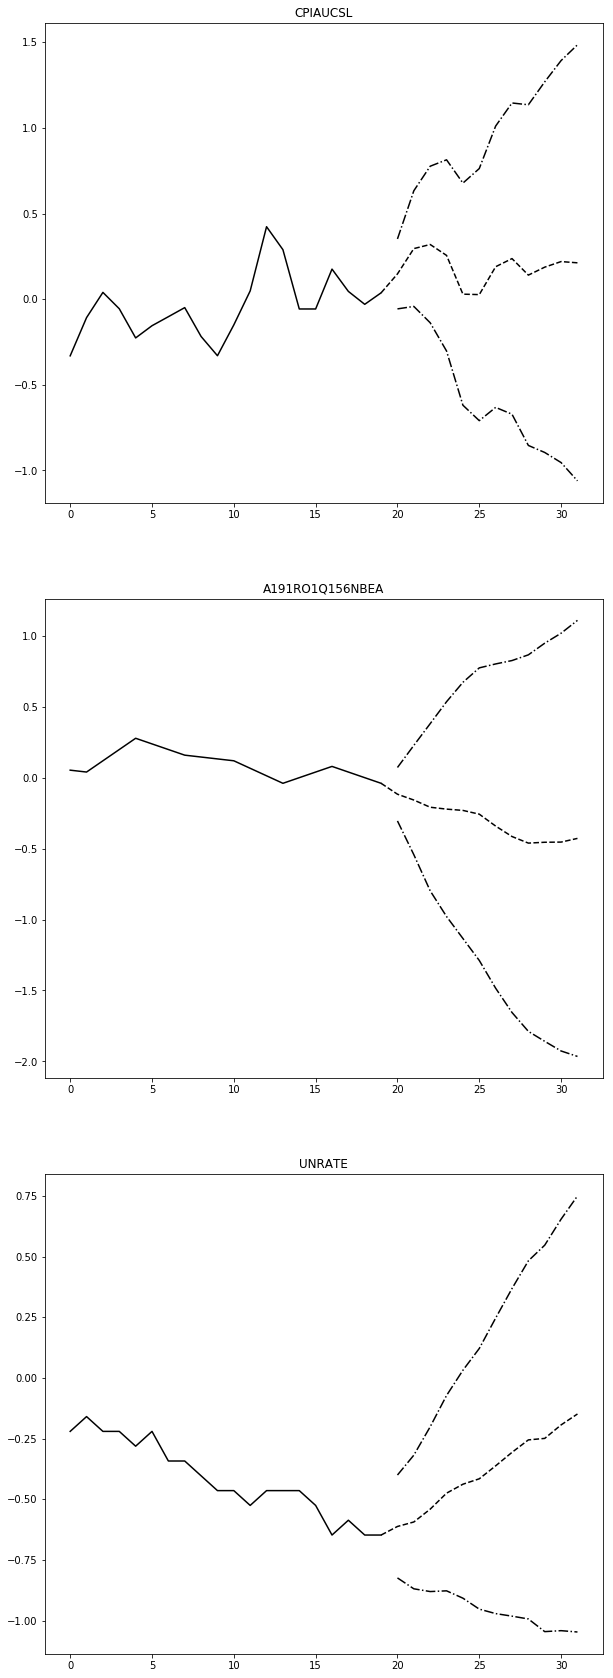

In [10]:
plot_forecast_custom(results, steps = 12)

In [11]:
lag_order = results.k_ar
forecasts = np.empty((len(test) - lag_order, 3))

for i in range(len(test) - lag_order):
    forecast = results.forecast(test.values[i:lag_order + i], steps=1)
    forecasts[i] = forecast

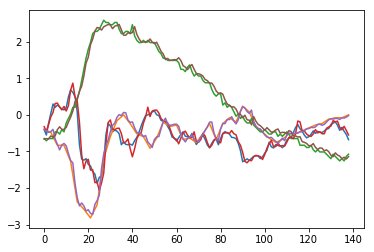

In [12]:
plt.plot(test.values[lag_order:])
plt.plot(forecasts)

In [13]:
from sklearn.metrics import mean_squared_error

In [14]:
mse = mean_squared_error(forecasts, test[lag_order:])
print("Average MSE on test set: " + str(mse))

Average MSE on test set: 0.01172952373250502
